In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

In [29]:
def measure_distortion():
    
    # prepare object points
    nx = 9
    ny = 6
    objpoints =[]
    imgpoints  = []
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] =np.mgrid[0:9, 0:6].T.reshape(-1,2)


    # Get list of calibarion images
    fnames = glob.glob('camera_cal/*.jpg')

    for fname in fnames:
    
        # Read image
        img = cv2.imread(fname)

        # Convert image to gray
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # Check if corners are found
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            #Draw corners on the original image
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img)
    return objpoints, imgpoints

In [30]:
def correct_distortion(img, objpoints, imgpoints):
    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    return undistort

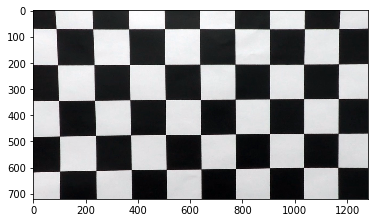

In [33]:
objpts, imgpts = measure_distortion()
img = cv2.imread('camera_cal/calibration1.jpg')

undist = correct_distortion(img, objpts, imgpts)
plt.imshow(undist)